In [1]:
!pip install cmake gym scipy

In [1]:
import pandas as pd
import seaborn as sns

In [98]:
import sys
from contextlib import closing
from io import StringIO
from gym import utils
from gym.envs.toy_text import discrete
import numpy as np

MAP = [
    "+---------+",
    "|R: | : :G|",
    "| : | : : |",
    "| : : : : |",
    "| | : | : |",
    "|Y| : |B: |",
    "+---------+",
]


taxi1_row, taxi1_col, pass_idx1, dest_idx1 = 0, 0, 0, 0
taxi2_row, taxi2_col, pass_idx2, dest_idx2 = 0, 0, 0, 0


class TaxiEnv_1(discrete.DiscreteEnv):
    """
    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich
    Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
    Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger
    Rewards:
    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
    """
    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self):
        global taxi2_row
        global taxi2_col
        
        self.desc = np.asarray(MAP, dtype='c')

        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        P = {state: {action: []
                     for action in range(num_actions)} for state in range(num_states)}
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1  # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                if taxi2_row == min(row + 1, max_row) and taxi2_col==col and \
                                    (taxi2_row, taxi2_col) not in self.locs:
                                    new_row = row
                                else:
                                    new_row = min(row + 1, max_row)
                            elif action == 1:
                                if taxi2_row == max(row - 1, 0) and taxi2_col==col and \
                                (taxi2_row, taxi2_col) not in self.locs:
                                    new_row = row
                                else:
                                    new_row = max(row - 1, 0)
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                if taxi2_row == row and taxi2_col==min(col + 1, max_col) and \
                                (taxi2_row, taxi2_col) not in self.locs:
                                    new_col = col
                                else:
                                    new_col = min(col + 1, max_col)
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                if taxi2_row == row and taxi2_col==max(col - 1, 0) and \
                                (taxi2_row, taxi2_col) not in self.locs:
                                    new_col = col
                                else:
                                    new_col = max(col - 1, 0)
                            elif action == 4:  # pickup
                                if (pass_idx < 4 and taxi_loc == locs[pass_idx]):
                                    new_pass_idx = 4
                                else:  # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 20
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else:  # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx)
                            P[state][action].append(
                                (1.0, new_state, reward, done))
        initial_state_distrib /= initial_state_distrib.sum()
        discrete.DiscreteEnv.__init__(
            self, num_states, num_actions, P, initial_state_distrib)

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def render(self, mode='human'):
        global taxi2_row
        global taxi2_col
        global pass_idx2
        global dest_idx2
        
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x): return "_" if x == " " else x
        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], 'yellow', highlight=True)
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
            
            if pass_idx2 < 4:
                out[1 + taxi2_row][2 * taxi2_col + 1] = utils.colorize(
                    out[1 + taxi2_row][2 * taxi2_col + 1], 'magenta', highlight=True)
            else:
                out[1 + taxi2_row][2 * taxi2_col + 1] = utils.colorize(
                    out[1 + taxi2_row][2 * taxi2_col + 1], 'green', highlight=True)

        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), 'green', highlight=True)
            
            if pass_idx2 < 4:
                out[1 + taxi2_row][2 * taxi2_col + 1] = utils.colorize(
                    out[1 + taxi2_row][2 * taxi2_col + 1], 'magenta', highlight=True)
            else:
                out[1 + taxi2_row][2 * taxi2_col + 1] = utils.colorize(
                    out[1 + taxi2_row][2 * taxi2_col + 1], 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], 'magenta')
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["South", "North", "East", "West", "Pickup", "Dropoff"][self.lastaction]))
        else:
            outfile.write("\n")

        # No need to return anything for human
        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()
            
    def update_location(self):
        global taxi1_row
        global taxi1_col
        global pass_idx1
        global dest_idx1
        taxi1_row, taxi1_col, pass_idx1, dest_idx1 = env.decode(self.s)

        
        
class TaxiEnv_2(discrete.DiscreteEnv):
    """
    The Taxi Problem
    from "Hierarchical Reinforcement Learning with the MAXQ Value Function Decomposition"
    by Tom Dietterich
    Description:
    There are four designated locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger's location, picks up the passenger, drives to the passenger's destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.
    Observations:
    There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. 
    Passenger locations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    - 4: in taxi
    Destinations:
    - 0: R(ed)
    - 1: G(reen)
    - 2: Y(ellow)
    - 3: B(lue)
    Actions:
    There are 6 discrete deterministic actions:
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger
    Rewards:
    There is a default per-step reward of -1,
    except for delivering the passenger, which is +20,
    or executing "pickup" and "drop-off" actions illegally, which is -10.
    Rendering:
    - blue: passenger
    - magenta: destination
    - yellow: empty taxi
    - green: full taxi
    - other letters (R, G, Y and B): locations for passengers and destinations
    state space is represented by:
        (taxi_row, taxi_col, passenger_location, destination)
    """
    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self):
        global taxi1_row
        global taxi1_col
        
        self.desc = np.asarray(MAP, dtype='c')

        self.locs = locs = [(0, 0), (0, 4), (4, 0), (4, 3)]

        num_states = 500
        num_rows = 5
        num_columns = 5
        max_row = num_rows - 1
        max_col = num_columns - 1
        initial_state_distrib = np.zeros(num_states)
        num_actions = 6
        P = {state: {action: []
                     for action in range(num_actions)} for state in range(num_states)}
        for row in range(num_rows):
            for col in range(num_columns):
                for pass_idx in range(len(locs) + 1):  # +1 for being inside taxi
                    for dest_idx in range(len(locs)):
                        state = self.encode(row, col, pass_idx, dest_idx)
                        if pass_idx < 4 and pass_idx != dest_idx:
                            initial_state_distrib[state] += 1
                        for action in range(num_actions):
                            # defaults
                            new_row, new_col, new_pass_idx = row, col, pass_idx
                            reward = -1  # default reward when there is no pickup/dropoff
                            done = False
                            taxi_loc = (row, col)

                            if action == 0:
                                if taxi1_row == min(row + 1, max_row) and taxi1_col==col and \
                                (taxi1_row, taxi1_col) not in self.locs:
                                    new_row = row
                                else:
                                    new_row = min(row + 1, max_row)
                                    
                            elif action == 1:
                                if taxi1_row == max(row - 1, 0) and taxi1_col==col and \
                                (taxi1_row, taxi1_col) not in self.locs:
                                    new_row = row
                                else:
                                    new_row = max(row - 1, 0)
                                    
                            if action == 2 and self.desc[1 + row, 2 * col + 2] == b":":
                                if taxi1_row == row and taxi1_col==min(col + 1, max_col) and \
                                (taxi1_row, taxi1_col) not in self.locs:
                                    new_col = col
                                else:
                                    new_col = min(col + 1, max_col)
                                
                            elif action == 3 and self.desc[1 + row, 2 * col] == b":":
                                if taxi1_row == row and taxi1_col==max(col - 1, 0) and \
                                (taxi1_row, taxi1_col) not in self.locs:
                                    new_col = col
                                else:
                                    new_col = max(col - 1, 0)
                                
                            elif action == 4:  # pickup
                                if (pass_idx < 4 and taxi_loc == locs[pass_idx]):
                                    new_pass_idx = 4
                                else:  # passenger not at location
                                    reward = -10
                            elif action == 5:  # dropoff
                                if (taxi_loc == locs[dest_idx]) and pass_idx == 4:
                                    new_pass_idx = dest_idx
                                    done = True
                                    reward = 20
                                elif (taxi_loc in locs) and pass_idx == 4:
                                    new_pass_idx = locs.index(taxi_loc)
                                else:  # dropoff at wrong location
                                    reward = -10
                            new_state = self.encode(
                                new_row, new_col, new_pass_idx, dest_idx)
                            P[state][action].append(
                                (1.0, new_state, reward, done))
        initial_state_distrib /= initial_state_distrib.sum()
        discrete.DiscreteEnv.__init__(
            self, num_states, num_actions, P, initial_state_distrib)

    def encode(self, taxi_row, taxi_col, pass_loc, dest_idx):
        # (5) 5, 5, 4
        i = taxi_row
        i *= 5
        i += taxi_col
        i *= 5
        i += pass_loc
        i *= 4
        i += dest_idx
        return i

    def decode(self, i):
        out = []
        out.append(i % 4)
        i = i // 4
        out.append(i % 5)
        i = i // 5
        out.append(i % 5)
        i = i // 5
        out.append(i)
        assert 0 <= i < 5
        return reversed(out)

    def render(self, mode='human'):
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        out = self.desc.copy().tolist()
        out = [[c.decode('utf-8') for c in line] for line in out]
        taxi_row, taxi_col, pass_idx, dest_idx = self.decode(self.s)

        def ul(x): return "_" if x == " " else x
        if pass_idx < 4:
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                out[1 + taxi_row][2 * taxi_col + 1], 'magenta', highlight=True)
            pi, pj = self.locs[pass_idx]
            out[1 + pi][2 * pj + 1] = utils.colorize(out[1 + pi][2 * pj + 1], 'blue', bold=True)
        else:  # passenger in taxi
            out[1 + taxi_row][2 * taxi_col + 1] = utils.colorize(
                ul(out[1 + taxi_row][2 * taxi_col + 1]), 'green', highlight=True)

        di, dj = self.locs[dest_idx]
        out[1 + di][2 * dj + 1] = utils.colorize(out[1 + di][2 * dj + 1], 'magenta')
        outfile.write("\n".join(["".join(row) for row in out]) + "\n")
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["South", "North", "East", "West", "Pickup", "Dropoff"][self.lastaction]))
        else:
            outfile.write("\n")

        # No need to return anything for human
        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue()
            
    def update_location(self):
        global taxi2_row
        global taxi2_col
        global pass_idx2
        global dest_idx2
        taxi2_row, taxi2_col, pass_idx2, dest_idx2 = env.decode(self.s)
        

In [3]:
env = TaxiEnv_1()
state = env.encode(2, 2, 0, 3)
print("State:", state)
env.s = state
env.update_location()
env.render()

State: 243
+---------+
|R: : : :G|
| : : : : |
| : : : : |
| : : : : |
|Y: : : :B|
+---------+



In [4]:
env2 = TaxiEnv_2()
state = env2.encode(1, 1, 1, 2)
print("State:", state)
env2.s = state
env2.update_location()
env2.render()

State: 126
+---------+
|R: : : :G|
| : : : : |
| : : : : |
| : : : : |
|Y: : : :B|
+---------+



In [5]:
env2.step(0)
env2.update_location()
env2.render()

+---------+
|R: : : :G|
| : : : : |
| : : : : |
| : : : : |
|Y: : : :B|
+---------+
  (South)


In [6]:
env2.step(2)
env2.update_location()
env2.render()

+---------+
|R: : : :G|
| : : : : |
| : : : : |
| : : : : |
|Y: : : :B|
+---------+
  (East)


In [7]:
env.render()

+---------+
|R: : : :G|
| : : : : |
| : : : : |
| : : : : |
|Y: : : :B|
+---------+



In [40]:
env.s = 243  # set environment to illustration's state
env2.s = 126  # set environment to illustration's state

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation
rewards = []

done = False
done2 = False

while (not done) or (not done2):
    
    if (not done):
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        env.update_location()

    if (not done2):
        action2 = env2.action_space.sample()
        state2, reward2, done2, info2 = env2.step(action2)
        env2.update_location()
    
    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    rewards.append(reward)

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))


Timesteps taken: 2404
Penalties incurred: 90


In [11]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print("Timestep: {}".format(i + 1))
        print("State: {}".format(frame['state']))
        print("Action: {}".format(frame['action']))
        print("Reward: {}".format(frame['reward']))
        sleep(.1)
        
print_frames(frames)

+---------+
|R: : : :G|
| : : : : |
| : : : : |
| : : : : |
|Y: : : :B|
+---------+
  (Pickup)

Timestep: 857
State: 283
Action: 4
Reward: -10


KeyboardInterrupt: 

In [41]:
env.s = env.reset()  # set environment to illustration's state
env2.s = env2.reset()  # set environment to illustration's state
env.update_location()
env2.update_location()

while (dest_idx1==pass_idx2 or dest_idx1==dest_idx2 or pass_idx1==dest_idx2 or pass_idx1==pass_idx2):
    env2.s = env2.reset() 
    env2.update_location()

for i in range(100):
    epochs = 0
    penalties, reward = 0, 0

    frames = [] # for animation
    rewards = []

    done = False
    done2 = False

    while (not done) or (not done2):

        if (not done):
            action = env.action_space.sample()
            state, reward, done, info = env.step(action)
            env.update_location()

        if (not done2):
            action2 = env2.action_space.sample()
            state2, reward2, done2, info2 = env2.step(action2)
            env2.update_location()

        if reward == -10:
            penalties += 1

        # Put each rendered frame into dict for animation
        frames.append({
            'frame': env.render(mode='ansi'),
            'state': state,
            'action': action,
            'reward': reward
            }
        )
        rewards.append(reward)

        epochs += 1


print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 1538
Penalties incurred: 291


In [67]:
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        print(frame['frame'])
        print("Timestep: {}".format(i + 1))
        print("State: {}".format(frame['state']))
        print("Action: {}".format(frame['action']))
        print("Reward: {}".format(frame['reward']))
        sleep(.1)
        
print_frames(frames)

+---------+
|R: : : :G|
| : : : : |
| : : : : |
| : : : : |
|Y: : : :B|
+---------+
  (Dropoff)

Timestep: 14
State: 495
Action: 2
Reward: 20


In [42]:
#First, we'll initialize the 2 Q-table to a 500×6 matrix of zeros:
import numpy as np
q_table1 = np.zeros([env.observation_space.n, env.action_space.n])
q_table2 = np.zeros([env.observation_space.n, env.action_space.n])

In [43]:
q_table1.shape
q_table2.shape

(500, 6)

In [73]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.9
epsilon = 0.4

# For plotting metrics
all_epochs_taxi1 = []
all_penalties_taxi1 = []
all_rewards_taxi1 = []
# For plotting metrics
all_epochs_taxi2 = []
all_penalties_taxi2 = []
all_rewards_taxi2 = []

for i in range(1, 100001):
    state = env.reset()
    env.update_location()
    
    state2 = env2.reset()
    env2.update_location()
    
    while (dest_idx1==pass_idx2 or dest_idx1==dest_idx2 or pass_idx1==dest_idx2 or pass_idx1==pass_idx2):
        env2.s = env2.reset() 
        env2.update_location()
    

    epochs, penalties, cum_reward = 0, 0, 0
    epochs2, penalties2, cum_reward2 = 0, 0, 0
    done = False
    done2 = False
    
    while (not done) or (not done2):
        ###############################
        # Taxi 1 Learning 
        ###############################
        
        if (not done):
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table1[state]) # Exploit learned values

            next_state, reward, done, info = env.step(action) 
            env.update_location()
            
            old_value = q_table1[state, action]
            next_max = np.max(q_table1[next_state])
            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table1[state, action] = new_value

            if reward == -10:
                penalties += 1

            state = next_state

            epochs += 1
            cum_reward += reward
        
        ###############################
        # Taxi 2 Learning
        ###############################
        
        if (not done2):
            if random.uniform(0, 1) < epsilon:
                action2 = env2.action_space.sample() # Explore action space
            else:
                action2 = np.argmax(q_table2[state2]) # Exploit learned values

            next_state2, reward2, done2, info2 = env2.step(action2) 
            env2.update_location()
            
            old_value2 = q_table2[state2, action2]
            next_max2 = np.max(q_table2[next_state2])
            new_value2 = (1 - alpha) * old_value2 + alpha * (reward2 + gamma * next_max2)
            q_table2[state2, action2] = new_value2

            if reward2 == -10:
                penalties2 += 1

            state2 = next_state2

            epochs2 += 1
            cum_reward2 += reward2
        
    all_epochs_taxi1.append(epochs)
    all_penalties_taxi1.append(penalties)
    all_rewards_taxi1.append(cum_reward)
    
    all_epochs_taxi2.append(epochs2)
    all_penalties_taxi2.append(penalties2)
    all_rewards_taxi2.append(cum_reward2)
    
#     if i % 10 == 0:
    clear_output(wait=True)
    print("Episode: {}".format(i))


print("Training finished.\n")


Episode: 100000
Training finished.

Wall time: 4min 28s


In [74]:
data_tuples = list(zip(list(range(1, 100001)), all_epochs_taxi1, all_penalties_taxi1, all_rewards_taxi1,all_epochs_taxi2, all_penalties_taxi2, all_rewards_taxi2))

In [75]:
learning_df = pd.DataFrame(data_tuples, columns=['episode','taxi1_epochs_to_complete','taxi1_penalties', 'taxi1_rewards', 'taxi2_epochs_to_complete','taxi2_penalties', 'taxi2_rewards'])

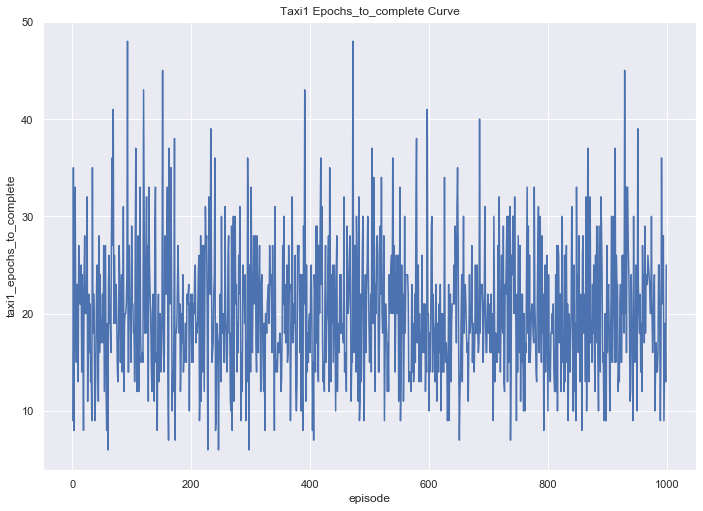

In [76]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.lineplot(x='episode', y='taxi1_epochs_to_complete',data = learning_df[learning_df.episode<1000]).set(title='Taxi1 Epochs_to_complete Curve')

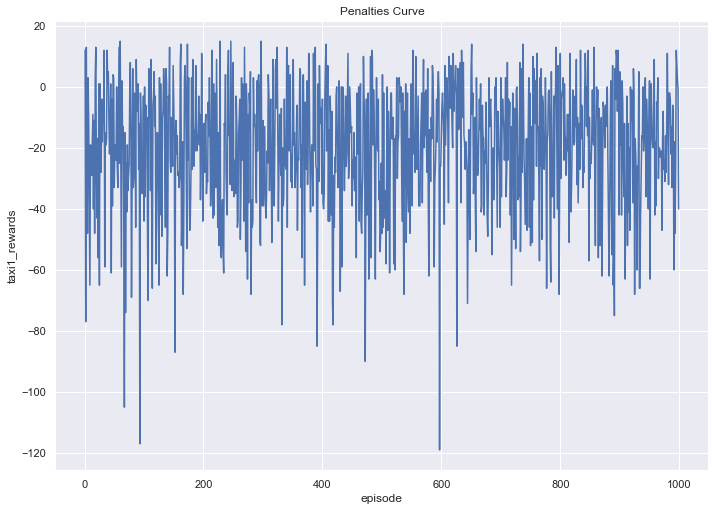

In [77]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.lineplot(x='episode', y='taxi1_rewards',data = learning_df[learning_df.episode<1000]).set(title='Penalties Curve')

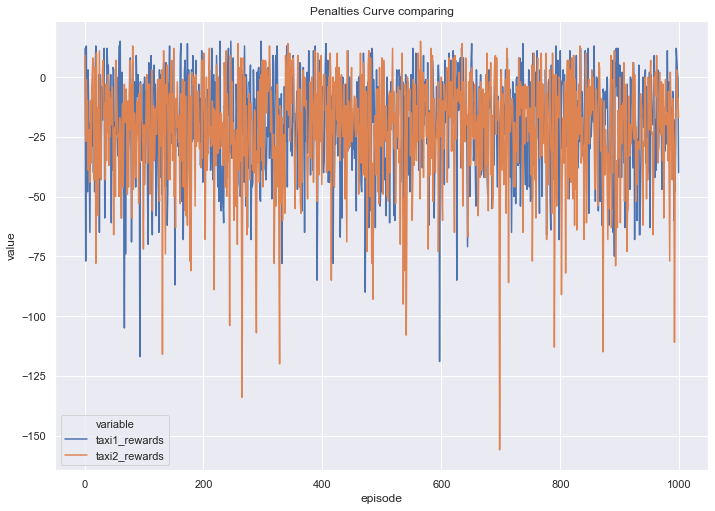

In [78]:
melt_penalities = pd.melt(learning_df[['episode','taxi1_rewards', 'taxi2_rewards']], ['episode'])
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.lineplot(x='episode', y='value', hue='variable',data = melt_penalities[melt_penalities.episode<1000]).set(title='Penalties Curve comparing')

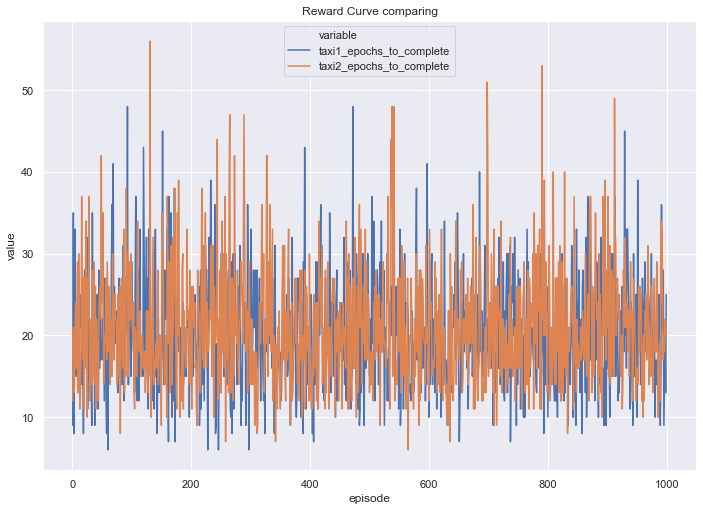

In [79]:
melt_epochs = pd.melt(learning_df[['episode','taxi1_epochs_to_complete', 'taxi2_epochs_to_complete']], ['episode'])
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns_plot = sns.lineplot(x='episode', y='value', hue='variable',data = melt_epochs[melt_epochs.episode<1000]).set(title='Reward Curve comparing')

In [96]:
env.s = 243  # set environment to illustration's state
env2.s = 126  # set environment to illustration's state

state = 243
state2= 100

epochs, total_reward = 0, 0

frames = [] # for animation

done = False
done2 = False

while (not done) or (not done2):
    
    if (not done):
        action = np.argmax(q_table1[state])
        state, reward, done, info = env.step(action)
        env.update_location()

    if (not done2):
        action2 = np.argmax(q_table2[state2])
        state2, reward2, done2, info2 = env2.step(action2)
        env2.update_location()
    
    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(mode='ansi'),
        'state': state,
        'action': action,
        'reward': reward
        }
    )
    total_reward += reward

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("reward incurred: {}".format(total_reward))

Timesteps taken: 16
reward incurred: 47


In [97]:
print_frames(frames)

+---------+
|R: : : :G|
| : : : : |
| : : : : |
| : : : : |
|Y: : : :B|
+---------+
  (Dropoff)

Timestep: 16
State: 495
Action: 5
Reward: 20


In [94]:
action2

5